<a href="https://colab.research.google.com/github/yxmauw/GA_Capstone/blob/main/Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="http://imgur.com/1ZcRyrc.png" width="70" height="70" align="left" style="margin: 20px"> 
 # Capstone: Glaucoma detection using Fundoscopy images

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'

In [2]:
# upload files to working directory each runtime
!git clone https://github.com/yxmauw/GA_Capstone.git # has to be public repository

fatal: destination path 'GA_Capstone' already exists and is not an empty directory.


In [3]:
all_labels = pd.read_csv('./GA_Capstone/glaucoma_labels.csv') # this works which is weird
all_labels.head(3)

,Filename,ExpCDR,Eye,Set,Glaucoma
0,001.jpg,0.7097,OD,A,0
1,002.jpg,0.6953,OS,A,0
2,003.jpg,0.9629,OS,A,0


In [4]:
# explore counts
all_labels['Glaucoma'].value_counts()
# 482 negative, 168 positive for glaucoma (contains both train, validation images)
# unbalanced data
# total 650 images

0    482
1    168
Name: Glaucoma, dtype: int64

In [24]:
import fnmatch
import os

# image files count
train_g_negative_count = len(fnmatch.filter(os.listdir('./GA_Capstone/Fundus_Scans/Train/Glaucoma_Negative'), '*.jpg'))
train_g_positive_count = len(fnmatch.filter(os.listdir('./GA_Capstone/Fundus_Scans/Train/Glaucoma_Positive'), '*.jpg'))
test_g_negative_count = len(fnmatch.filter(os.listdir('./GA_Capstone/Fundus_Scans/Validation/Glaucoma_Negative'), '*.jpg'))
test_g_positive_count = len(fnmatch.filter(os.listdir('./GA_Capstone/Fundus_Scans/Validation/Glaucoma_Positive'), '*.jpg'))
total_image_count = train_g_negative_count + train_g_positive_count + \
                    test_g_negative_count + test_g_positive_count
# print count
print('---Train images---')
print('Glaucoma Negative:', train_g_negative_count)
print('Glaucoma Positive:', train_g_positive_count)
print()
print('---Validation iamges---')
print('Glaucoma Negative:', test_g_negative_count)
print('Glaucoma Positive:', test_g_positive_count)
print()
print('---Total image count---')
print(total_image_count)

---Train images---
Glaucoma Negative: 386
Glaucoma Positive: 134

---Validation iamges---
Glaucoma Negative: 96
Glaucoma Positive: 34

---Total image count---
650


In [5]:
# load example image
from PIL import Image 
im = Image.open('./GA_Capstone/Fundus_Scans/Train/Glaucoma_Positive/036.jpg')
# summarize some details about the image
print(im.format)
print(im.mode)
print(im.size)

pixels = np.asarray(im)
print(pixels[0])

JPEG
RGB
(3072, 2048)
[[1 3 0]
 [1 3 0]
 [1 3 0]
 ...
 [1 3 0]
 [1 3 0]
 [1 3 0]]


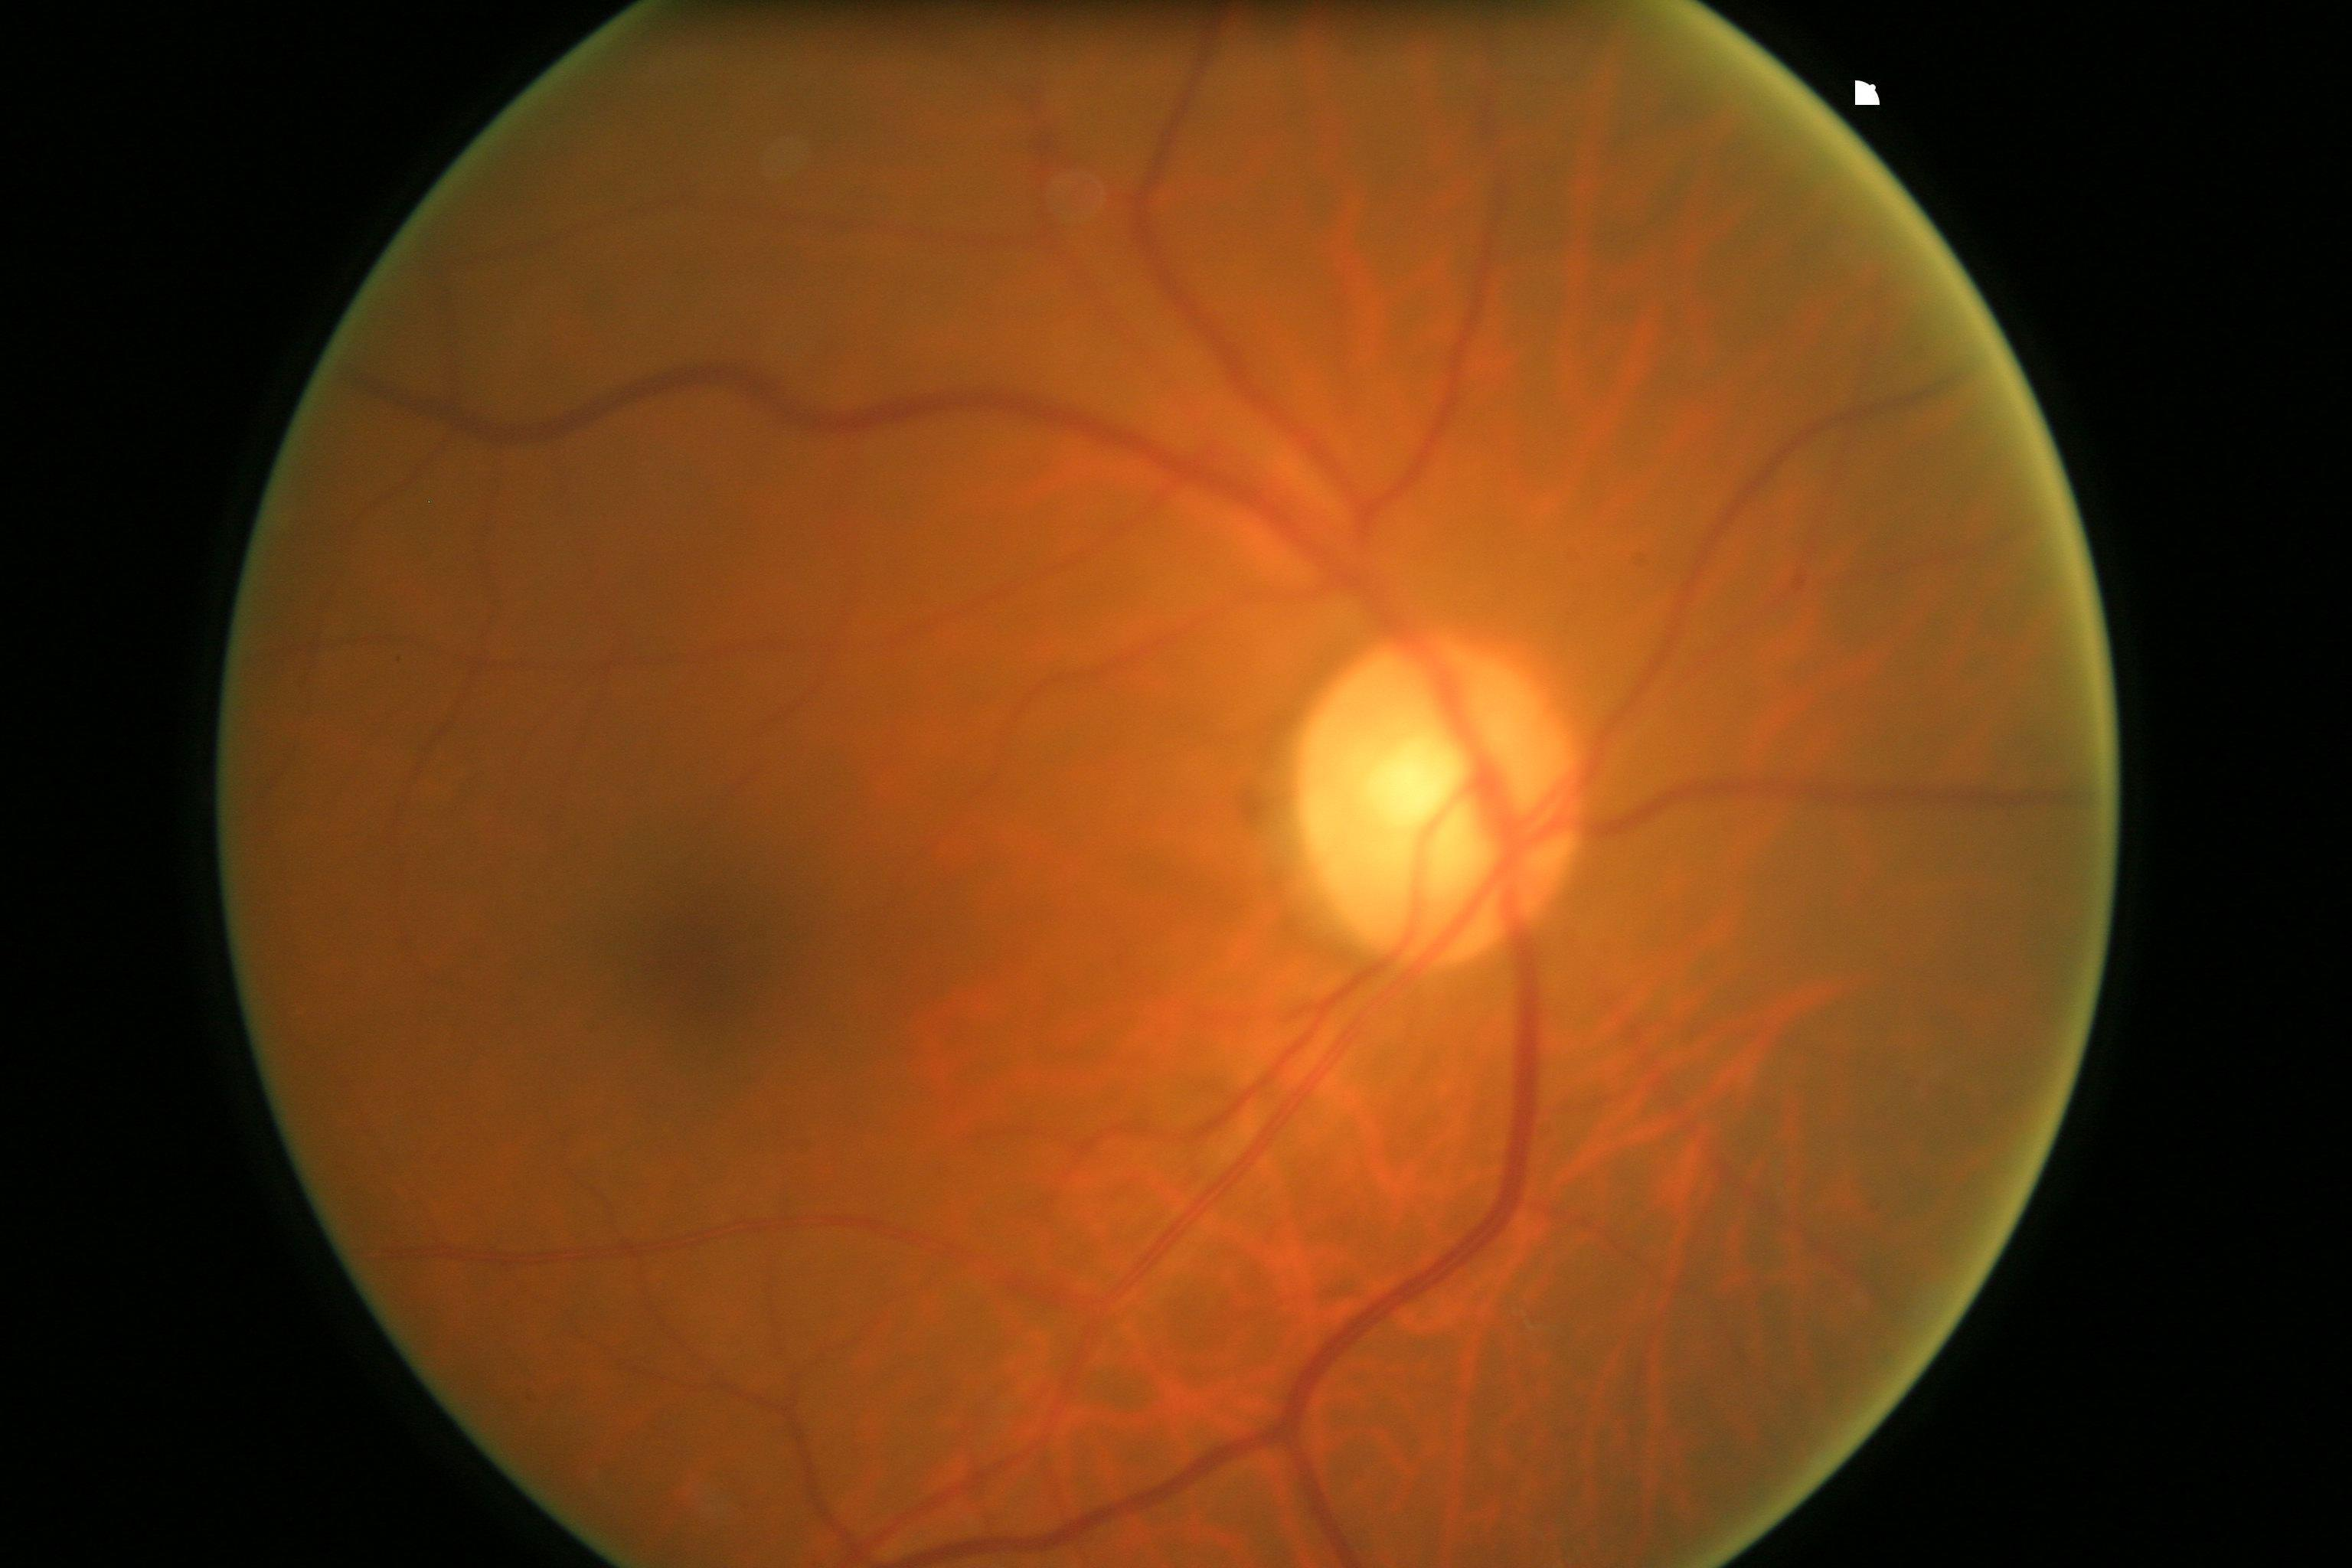

In [6]:
#Import library
from IPython import display
display.Image(filename='./GA_Capstone/Fundus_Scans/Train/Glaucoma_Positive/036.jpg', width=300, height=200)

In [7]:
# global centering similar to minmaxscaler

# calculate global mean
mean = pixels.mean()
print('Mean: %.3f' % mean)
# confirm pixel range is 0-255
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

print('Data Type: %s' % pixels.dtype)
pixels = pixels.astype('float32') # convert dtype to float

# normalize to the range 0-1
pixels /= 255.0
print() # gap for readability

# confirm it had the desired effect
mean = pixels.mean()
print('Normalised Mean: %.3f' % mean)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
print() # gap for readability
print(pixels[0])

Mean: 63.332
Min: 0.000, Max: 255.000
Data Type: uint8

Normalised Mean: 0.248
Min: 0.000, Max: 1.000

[[0.00392157 0.01176471 0.        ]
 [0.00392157 0.01176471 0.        ]
 [0.00392157 0.01176471 0.        ]
 ...
 [0.00392157 0.01176471 0.        ]
 [0.00392157 0.01176471 0.        ]
 [0.00392157 0.01176471 0.        ]]


## Visualisation

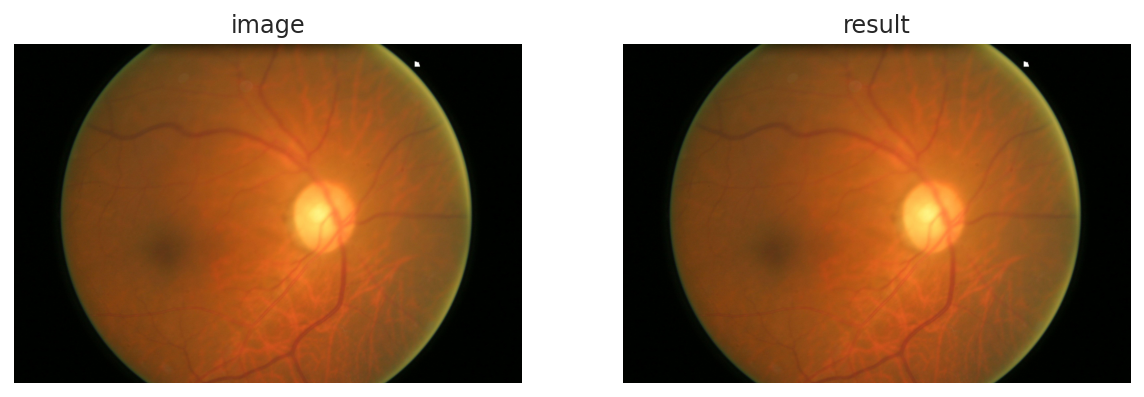

In [12]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,8))
ax0.imshow(im)
ax0.axis('off')
ax0.set_title('image')
# after pixel normalisation
ax1.imshow(pixels)
ax1.axis('off')
ax1.set_title('result')
plt.show() # result seems to have slight blurring of image, but still have good distinction of optic disc

## Image labelling

In [27]:
import tensorflow as tf
print(tf.__version__) #2.8.2

2.8.2


In [31]:
# generate dataset that can be used for machine learning
from tensorflow.keras.utils import image_dataset_from_directory

image_size = (256, 256) # scaled for model
batch_size = 32

train_ds = image_dataset_from_directory(
    './GA_Capstone/Fundus_Scans/Train/',
    image_size=image_size,
    labels='inferred',
    label_mode='binary', # binary crossentropy
    shuffle=True,
    seed=1,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    './GA_Capstone/Fundus_Scans/Validation/',
    image_size=image_size,
    labels='inferred',
    label_mode='binary', # binary crossentropy
    shuffle=True,
    seed=1,
    batch_size=batch_size
)

Found 520 files belonging to 2 classes.
Found 130 files belonging to 2 classes.


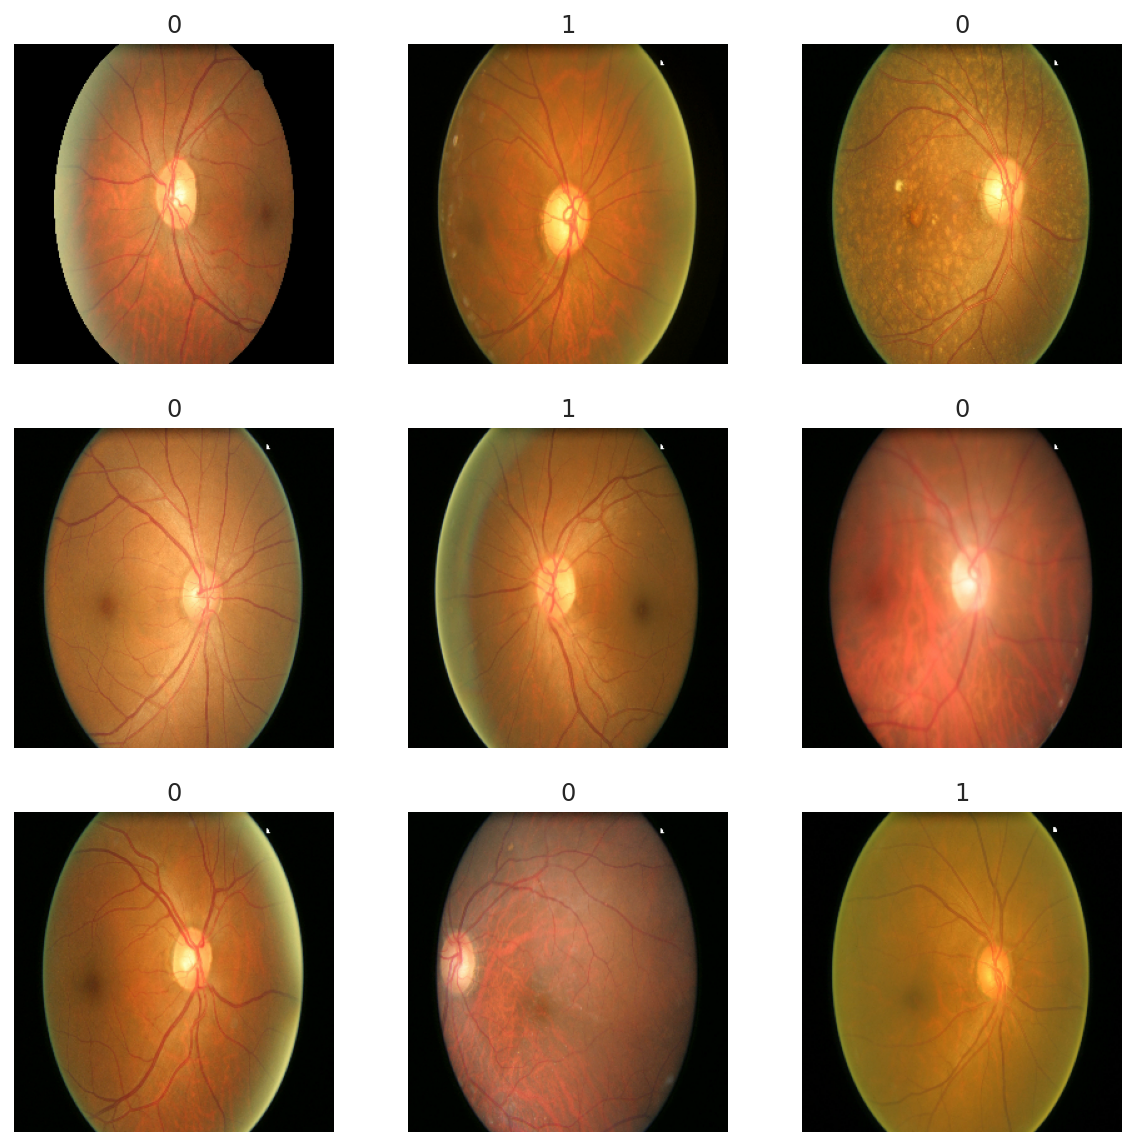

In [46]:
# preview of how images are labelled
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): # images scaled 255 x 255
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Image data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)